In [2]:
import pandas as pd
import numpy as np
import scipy
import os
import os.path
from matplotlib import cm
from IPython.display import display, HTML

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from bokeh.plotting import figure, output_file
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral3
import matplotlib as mpl
mpl.rcParams['font.family'] = 'DejaVu Sans'

## The data

In [3]:
def func(x):
    #wethermarkers=['☔','☀️','☃','☂','❄']
    if x.Temperature<=0 and x.Precipitation<10:
        return '☃','#d1d1e0'
    elif x.Temperature<=0 and x.Precipitation>=10:
        return '❄','#d1d1e0'
    elif x.Temperature>0 and x.Precipitation>=10 and x.Precipitation<30:
        return '☂','#009900'
    elif x.Temperature>0 and x.Precipitation>=30:
        return '☔','#7700b3'
    else:
        return '☀️','#ffff33'

df = pd.read_csv("data/homog_mo_SMA.txt", delimiter=r"\s+")

df['weather']=df.apply(func, axis=1)
df.head()

,Year,Month,Temperature,Precipitation,weather
0,1864,1,-6.6,25.7,"(❄, #d1d1e0)"
1,1864,2,-1.5,32.9,"(❄, #d1d1e0)"
2,1864,3,4.5,51.0,"(☔, #7700b3)"
3,1864,4,6.8,46.9,"(☔, #7700b3)"
4,1864,5,12.3,78.4,"(☔, #7700b3)"


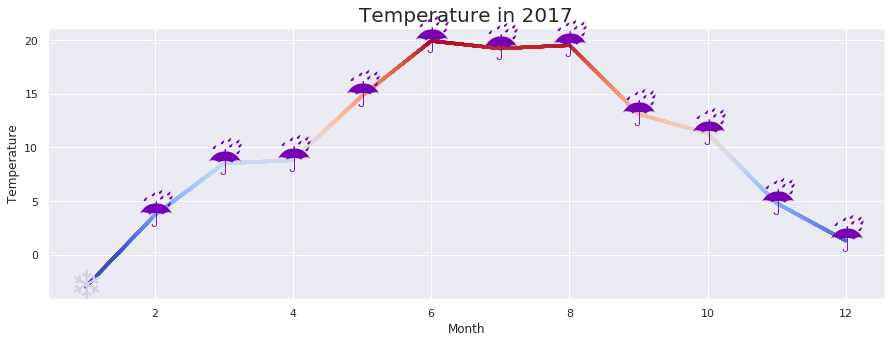

In [37]:
from scipy import stats
def plotYear(year,df):
    fig,ax=plt.subplots(figsize=(15,5))
    df2=df[df.Year==year]
    plt.set_cmap('coolwarm')
    for m in range(len(df2)):
        xy=(df2['Month'].iloc[m],df2['Temperature'].iloc[m])
        sym=df2['weather'].iloc[m][0]
        col=df2['weather'].iloc[m][1]
        ax.annotate(sym, xy=xy,size=40,c=col,horizontalalignment='center',verticalalignment='center')
        if m>0:
            slope, interc, _, _, _=stats.linregress([df2['Month'].iloc[m-1],df2['Month'].iloc[m]],
                                                    [df2['Temperature'].iloc[m-1],df2['Temperature'].iloc[m]])
        
            x=np.arange(df2['Month'].iloc[m-1],df2['Month'].iloc[m],0.001)
            y=interc+slope*x
            ax.scatter(x,y,c=cm.coolwarm(y/np.max(df2['Temperature'])),s=5)
        
    ax.set_title('Temperature in %s'%year, fontdict={'fontsize': 20, 'fontweight': 'medium'})
    ax.set_xlabel('Month')
    ax.set_ylabel('Temperature')
plotYear(2017,df)
plt.show()

<IPython.core.display.Javascript object>


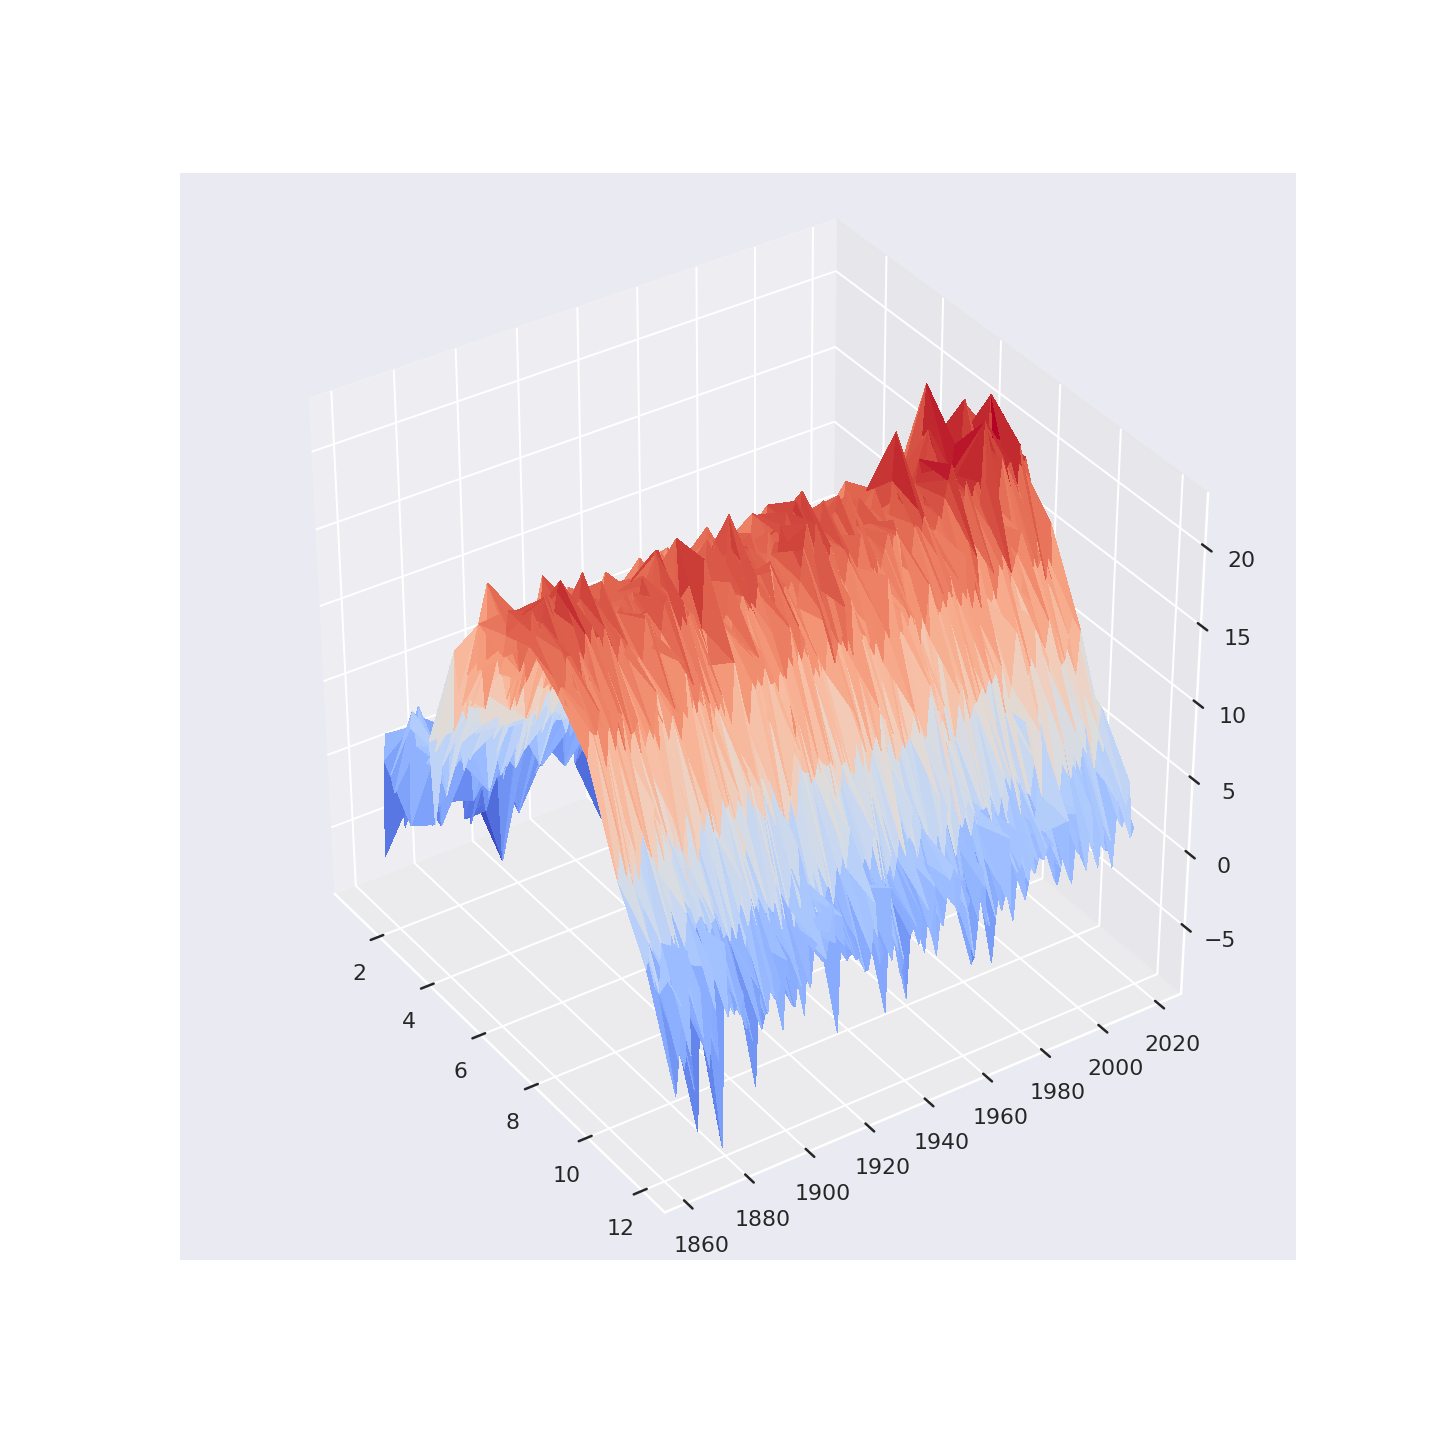

In [115]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_trisurf(df.Month, df.Year, df.Temperature, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.show()

## 4 Season trends

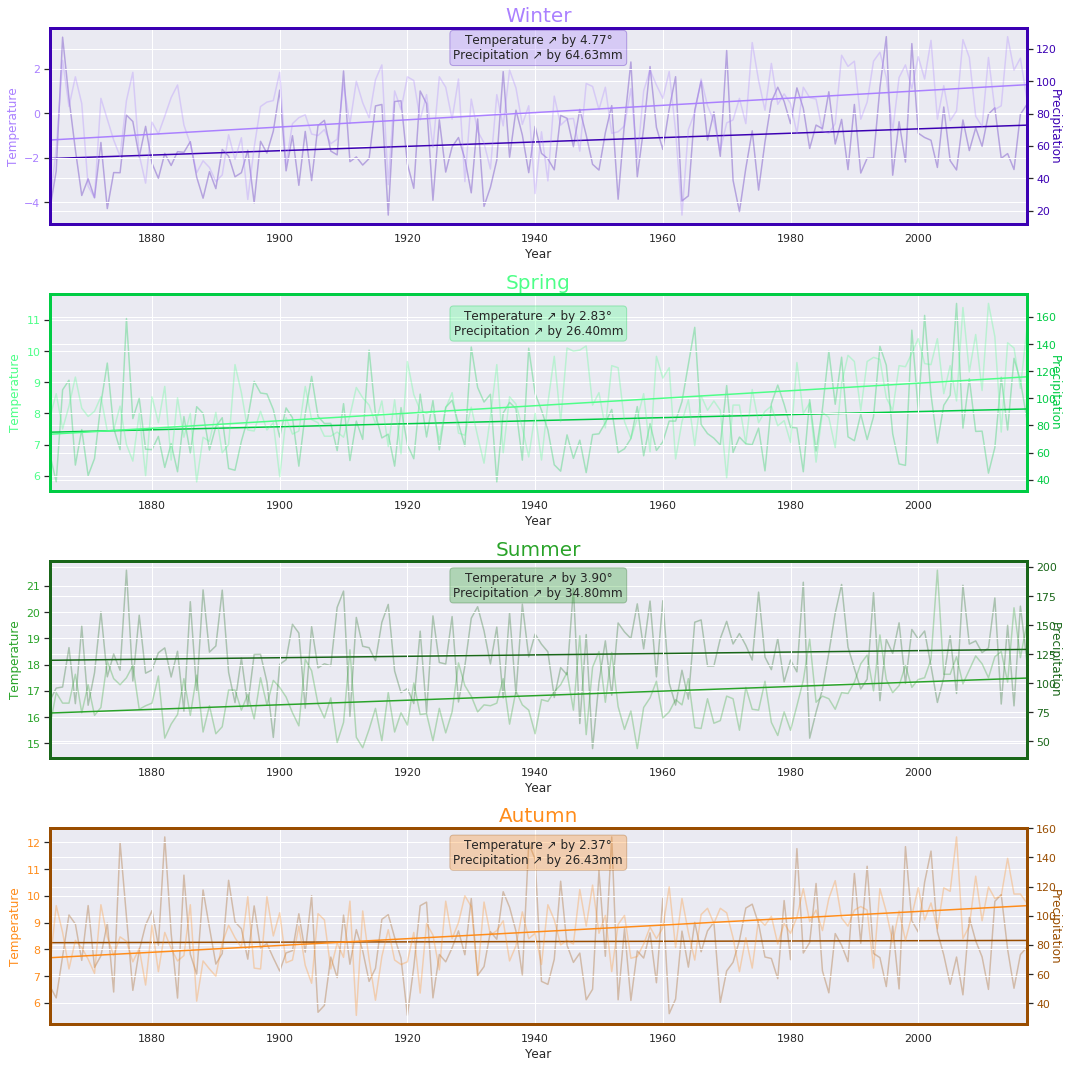

In [81]:
fig,ax=plt.subplots(4,1,figsize=(15,15))
Seasons={'Winter':[1,2,12],'Spring':[3,4,5],'Summer':[6,7,8],'Autumn':[9,10,11]}
Colors_t={'Winter':'#aa80ff','Summer':'#29a329','Autumn':'#ff8c1a','Spring':'#4dff88'}
Colors_p={'Winter':'#3b00b3','Summer':'#196619','Autumn':'#994d00','Spring':'#00cc44'}
ax=ax.reshape(-1)
for i,season in enumerate(Seasons):   
    df2=df[df['Month'].isin(Seasons[season])].groupby('Year').agg({'Year':'first','Temperature':'mean','Precipitation':'mean'})
    ax[i].spines["top"].set_color(Colors_p[season])
    ax[i].spines["left"].set_color(Colors_p[season])
    ax[i].spines["right"].set_color(Colors_p[season])
    ax[i].spines["bottom"].set_color(Colors_p[season])
    ax[i].spines["bottom"].set_linewidth(3)
    ax[i].spines["top"].set_linewidth(3)
    ax[i].spines["right"].set_linewidth(3)
    ax[i].spines["left"].set_linewidth(3)
    ax[i].plot(df2.Year,df2.Temperature,c=Colors_t[season],alpha=0.3)
    ax[i].set_title(season,fontsize=20,color=Colors_t[season])
    ax[i].set_xlabel('Year')
    ax[i].set_ylabel('Temperature',color=Colors_t[season])
    ax[i].tick_params(axis='y', labelcolor=Colors_t[season])
    ax2 = ax[i].twinx() 
    ax2.set_zorder(-1)
    ax[i].patch.set_visible(False)
    ax2.patch.set_visible(True)
    yy=ax2.set_ylabel('Precipitation',color=Colors_p[season])
    ax2.plot(df2.Year,df2.Precipitation,c=Colors_p[season],alpha=0.3)
    ax2.tick_params(axis='y', labelcolor=Colors_p[season])
    yy.set_rotation(-90)
    ax[i].set_xlim(min(df.Year),max(df.Year))
    slope, interc, _, _, _=stats.linregress(df2.Year,df2.Temperature)
    ax[i].plot(df2.Year,slope*df2.Year+interc,c=Colors_t[season])
    slope, interc, _, _, _=stats.linregress(df2.Year,df2.Precipitation)
    ax2.plot(df2.Year,slope*df2.Year+interc,c=Colors_p[season])
    dd=df2.Temperature[df2.Year==max(df2.Year)].values-df2.Temperature[df2.Year==min(df2.Year)].values
    pl="↗" if dd>0 else "↘"
    dd2=df2.Precipitation[df2.Year==max(df2.Year)].values-df2.Precipitation[df2.Year==min(df2.Year)].values
    pl2="↗" if dd2>0 else "↘"
    ax[i].text(min(df.Year)+(max(df.Year)-min(df.Year))/2,max(df2.Temperature)-1,'Temperature %s by %0.2f°\nPrecipitation %s by %0.2fmm'%(pl,dd,pl2,dd2),
               bbox=dict(boxstyle="round", alpha=0.3,ec=Colors_p[season], fc=Colors_t[season]),horizontalalignment='center')
plt.tight_layout()
plt.savefig('4Season.png')
plt.show()


Text(1864, 7.49305404273146, '')

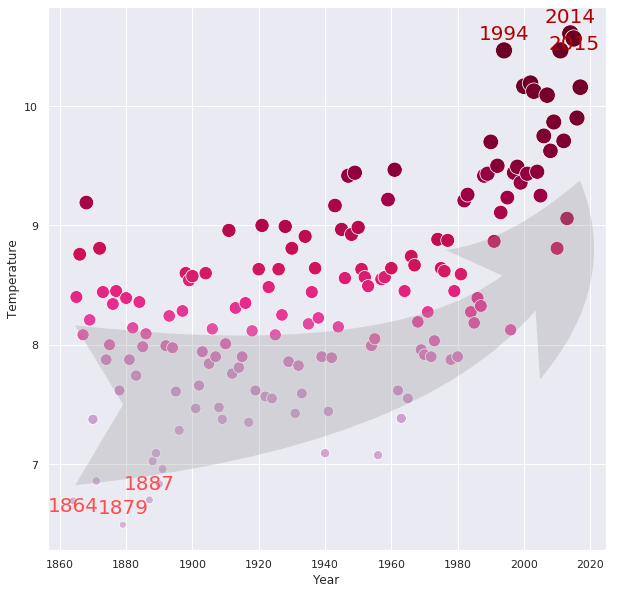

In [60]:
plt.figure(figsize=(10,10))

df2=df.groupby('Year').agg({'Year':'first','Temperature':'mean','Precipitation':'mean'}).drop(columns='Year').reset_index()
palette = sns.color_palette('PuRd',len(df2.Temperature.unique())+50)
palette = palette[50:]

ax=sns.scatterplot(x='Year',y='Temperature',size='Temperature',data=df2,sizes=(50,300),hue='Temperature',palette=palette,legend=False)
dfl=df2.nlargest(3, 'Temperature')
p=1
for i in range(3):
    ax.text(dfl.iloc[i].Year,dfl.iloc[i].Temperature+0.09*p,'%0.0f'%dfl.iloc[i].Year,fontsize=20,horizontalalignment='center',color='#b30000')
    p=p*-1
    
dfl=df2.nsmallest(3, 'Temperature')
p=1
for i in range(3):
    ax.text(dfl.iloc[i].Year,dfl.iloc[i].Temperature+0.09*p,'%0.0f'%dfl.iloc[i].Year,fontsize=20,horizontalalignment='center',color='#ff4d4d')
    p=p*-1
slope, interc, _, _, _=stats.linregress(df2.Year,df2.Temperature)
xy=(min(df2.Year),min(df2.Year)*slope+interc)

ax.annotate(s='',xy=(max(df2.Year),max(df2.Year)*slope+interc),xytext=(min(df2.Year),min(df2.Year)*slope+interc),
            size=400, arrowprops=dict(arrowstyle="fancy",fc="0.6", ec="none",alpha=0.3,
            connectionstyle="angle3,angleA=0,angleB=-100"))
    
    
    
    

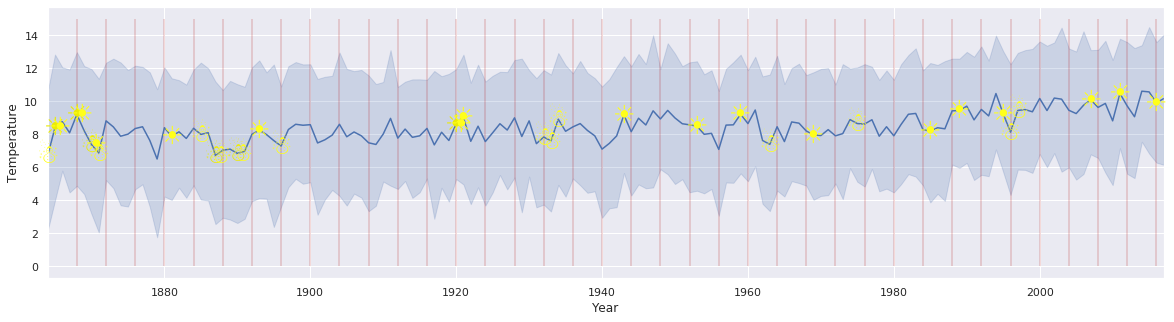

In [32]:
plt.figure(figsize=(20,5))
df2=df.groupby('Year').agg({'Year':'first','Temperature':'mean','Precipitation':'mean'}).drop(columns='Year').reset_index()
ax=sns.lineplot(data=df,x='Year',y='Temperature')
ax.set_xlim(min(df2.Year),max(df2.Year))
for year in df2.Year:
    df3=df[(df.Year==year)&(df.Precipitation<10)]
    if len(df3)>0:
        k=np.arange(0,20*len(df3),20)
        k=np.flip(k)
        for i in range(len(df3)):
            xy=(year+0.7*i,df[df.Year==year].groupby('Year').Temperature.mean().values)
            sym=df3['weather'].iloc[i][0]
            col=df3['weather'].iloc[i][1]
            ax.annotate(sym, xy=xy,size=25,c=[(255-k[i])/255, (255-k[i])/255, (26-k[i])/255],horizontalalignment='center',verticalalignment='center')

            
ax.vlines(np.arange(min(df2.Year),max(df2.Year),4),color='#b30000',alpha=0.2,ymin=0,ymax=15)

In [17]:
df2=df.groupby('Year').agg({'Year':'first','Temperature':'mean','Precipitation':'mean'}).drop(columns='Year').reset_index()
df[(df.Year==1881)&(df.Precipitation<10)]

,Year,Month,Temperature,Precipitation,weather
214,1881,11,4.6,8.1,"(☀️, #ffff33)"


(714415.0, 736330.0)

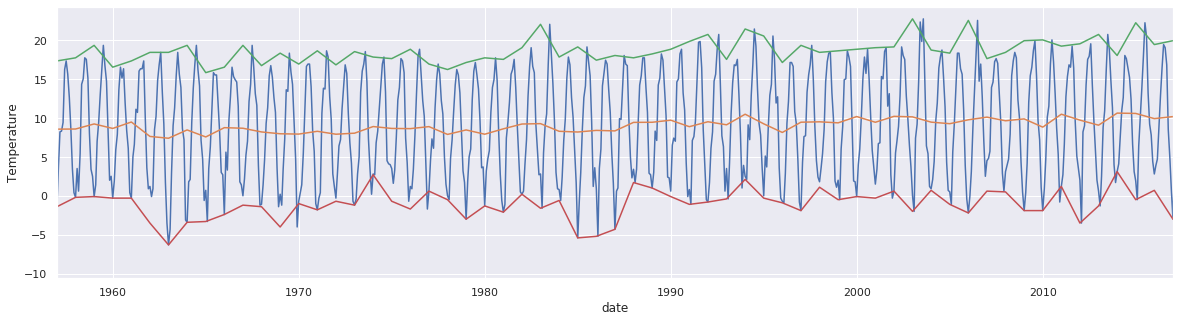

In [66]:
def func2(x):
    if x.Month<10:
        return str(x.Year)+'-0'+str(x.Month)
    else:
        return str(x.Year)+'-'+str(x.Month)

plt.figure(figsize=(20,5))
df['date']=df.apply(func2,axis=1)
df['date']=pd.to_datetime(df['date'])
ax=sns.lineplot(data=df,y='Temperature',x='date')
df5=df.groupby(df.date.dt.year).agg({'Year':'first','Temperature':'mean','Precipitation':'mean'}).reset_index()
df5['date']=pd.to_datetime(df5['date'].astype('str'))
sns.lineplot(data=df5,y='Temperature',x='date',ax=ax)
df5=df.groupby(df.date.dt.year).agg({'Year':'first','Temperature':'max','Precipitation':'mean'}).reset_index()
df5['date']=pd.to_datetime(df5['date'].astype('str'))
sns.lineplot(data=df5,y='Temperature',x='date',ax=ax)
ax.set_xlim('1957','2017')
df5=df.groupby(df.date.dt.year).agg({'Year':'first','Temperature':'min','Precipitation':'mean'}).reset_index()
df5['date']=pd.to_datetime(df5['date'].astype('str'))
sns.lineplot(data=df5,y='Temperature',x='date',ax=ax)
ax.set_xlim('1957','2017')


In [63]:
df5.head(10)

,date,Year,Temperature,Precipitation
0,1864,1864,6.691667,54.158333
1,1865,1865,8.400000,55.683333
2,1866,1866,8.758333,100.566667
3,1867,1867,8.083333,108.491667
4,1868,1868,9.191667,71.341667
5,1869,1869,8.208333,81.258333
6,1870,1870,7.375000,67.741667
7,1871,1871,6.858333,64.358333
8,1872,1872,8.808333,98.116667
9,1873,1873,8.441667,86.983333


In [40]:

s="PAYPALISHIRING"
numRows=4

import copy
d={}
direction='down'
l=copy.deepcopy(numRows-1)
pos=0

for i in range(numRows):
    d[i]=[]

while pos!=len(s):
    if direction=='down':
        for i in range(numRows):
            d[i].append(s[pos])
            pos+=1
            if pos==len(s):
                break
        direction='up'
    else:
        while l!=1:
            d[l-1].append(s[pos])
            pos+=1
            l-=1
            if pos==len(s):
                break
        l=copy.deepcopy(numRows-1)
        direction='down'
ans=''

ans=sum(d.values(), [])
ans=''.join(ans)
print(ans)
print("PINALSIGYAHRPI")        


PINALSIGYAHRPI
PINALSIGYAHRPI
